In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import io
import py7zr
from chunk_pipeline import *
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


In [2]:
ticker = 'RL'
archive_path = f"/nfs/home/jingt/dissertation-iceberg/data/training_data/_data_dwn_32_210_hidden_liquidity_{ticker}_2012-01-01_2012-12-31_1.7z"

model_path = "/nfs/home/jingt/dissertation-iceberg/data/output_folder"
model_name = f"xgboost_{ticker}.json"
model_path = os.path.join(model_path, model_name)
model = xgb.Booster()
model.load_model(model_path)



In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Set the seed for reproducibility
np.random.seed(42)

# Define the custom business day with the US Federal Holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Define the date range for the year 2012
date_range = pd.date_range(start='2012-01-01', end='2012-12-31', freq=us_bd)

# Randomly sample 10 trading days from the list
sampled_days = np.random.choice(date_range, 20, replace=False)

# Convert to a list of strings for easier readability
sampled_days_list = [pd.to_datetime(day).strftime('%Y-%m-%d') for day in sampled_days]

# Output the sampled days
print(sampled_days_list)


['2012-08-13', '2012-01-11', '2012-08-24', '2012-03-29', '2012-06-13', '2012-09-20', '2012-10-15', '2012-12-27', '2012-01-17', '2012-06-20', '2012-09-11', '2012-11-09', '2012-11-14', '2012-07-20', '2012-04-09', '2012-11-23', '2012-10-10', '2012-01-25', '2012-06-22', '2012-02-07']


In [4]:
import py7zr
import io
import pandas as pd

def ML_features(ticker, archive_path, specific_dates=None):
    features_lst = []
    output_lst = []

    with py7zr.SevenZipFile(archive_path, mode='r') as archive:
        filenames = archive.getnames()
        
        if not specific_dates:
            orderbook_files = [f for f in filenames if 'orderbook' in f]
            message_files = [f for f in filenames if 'message' in f]
        else:
            # Filter files for each date in the specific_dates list
            orderbook_files = [f for f in filenames if 'orderbook' in f and any(date in f for date in specific_dates)]
            message_files = [f for f in filenames if 'message' in f and any(date in f for date in specific_dates)]
        
        for orderbook_file, message_file in zip(orderbook_files, message_files):
            extracted_files = archive.read([orderbook_file, message_file])
            orderbook_stream = io.BytesIO(extracted_files[orderbook_file].read())
            message_stream = io.BytesIO(extracted_files[message_file].read())
            print("Processed files:", orderbook_file, message_file, flush=True)

            # Read the entire CSV files
            orderbook_df = pd.read_csv(orderbook_stream, header=None, usecols=[0, 1, 2, 3])
            message_df = pd.read_csv(message_stream, header=None, usecols=[0, 1, 2, 3, 4, 5])

            ticker, date = extract_info_from_filename(message_file)

            # Process data for prediction
            message_df = add_date_ticker(message_df, date, ticker)
            message_df, orderbook_df = data_preprocessing(message_df, orderbook_df, ticker_name=ticker)
            X, y = prediction_feature(message_df, orderbook_df, labelled=True, standardise=True)
            # Map classes from -1 to 0
            y = y.replace(-1, 0)
            y = y.astype(int)
            features_lst.append(X)
            output_lst.append(y)
        
    return pd.concat(features_lst), pd.concat(output_lst)



In [5]:
df_features, df_output = ML_features(ticker=ticker, archive_path=archive_path, specific_dates=sampled_days_list)

Processed files: RL_2012-01-11_34200000_57600000_orderbook_1.csv RL_2012-01-11_34200000_57600000_message_1.csv


Processed files: RL_2012-01-17_34200000_57600000_orderbook_1.csv RL_2012-01-17_34200000_57600000_message_1.csv
Processed files: RL_2012-01-25_34200000_57600000_orderbook_1.csv RL_2012-01-25_34200000_57600000_message_1.csv
Processed files: RL_2012-02-07_34200000_57600000_orderbook_1.csv RL_2012-02-07_34200000_57600000_message_1.csv
Processed files: RL_2012-03-29_34200000_57600000_orderbook_1.csv RL_2012-03-29_34200000_57600000_message_1.csv
Processed files: RL_2012-04-09_34200000_57600000_orderbook_1.csv RL_2012-04-09_34200000_57600000_message_1.csv
Processed files: RL_2012-06-13_34200000_57600000_orderbook_1.csv RL_2012-06-13_34200000_57600000_message_1.csv
Processed files: RL_2012-06-20_34200000_57600000_orderbook_1.csv RL_2012-06-20_34200000_57600000_message_1.csv
Processed files: RL_2012-06-22_34200000_57600000_orderbook_1.csv RL_2012-06-22_34200000_57600000_message_1.csv
Processed files: RL_2012-07-20_34200000_57600000_orderbook_1.csv RL_2012-07-20_34200000_57600000_message_1.csv
P

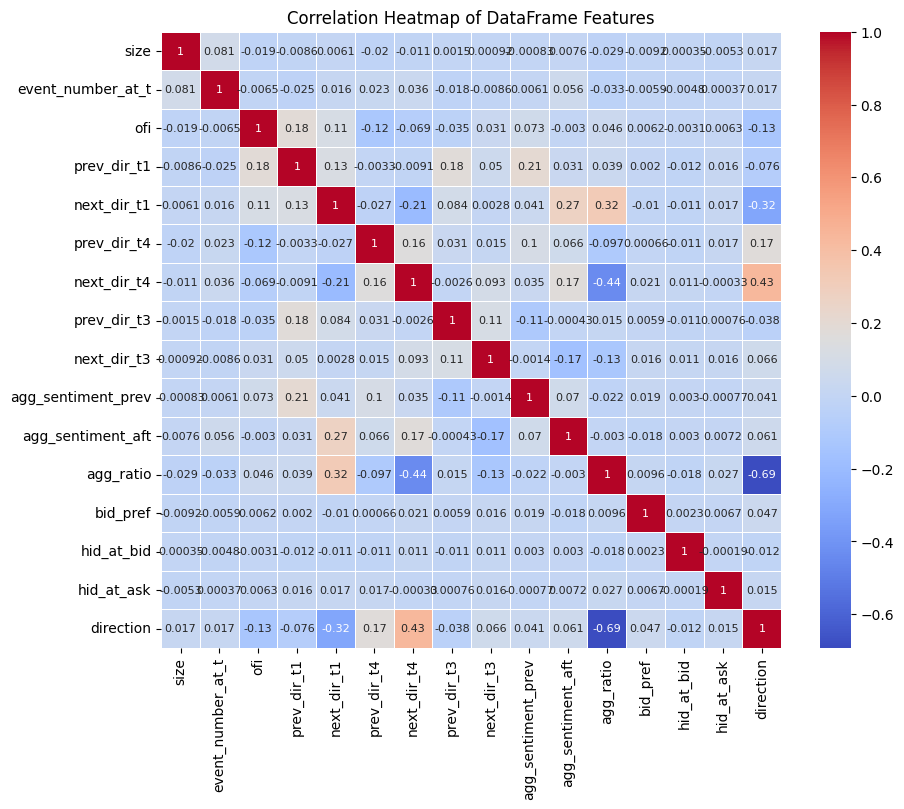

In [6]:
df_features_dropped = df_features.drop(columns=['event_number_at_t', 'hid_at_ask'])

correlation_matrix = df_features.merge(df_output, left_index=True, right_index=True).corr()
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of DataFrame Features')
plt.show()

In [13]:
ticker_lst = ['AES', 'ALB', 'AOS', 'APA', 'BEN', 'BXP', 'CPB',
                'DVA', 'FFIV', 'FRT', 'HII', 'HRL', 'HSIC', 'INCY',
                'MHK', 'NWSA', 'PNW', 'RL', 'TAP', 'WYNN']

feature_importances = {i: [] for i in df_features.columns}
num_models = len(ticker_lst)

for ticker in ticker_lst:
    model_path = "/nfs/home/jingt/dissertation-iceberg/data/output_folder"
    model_name = f"xgboost_{ticker}.json"
    model_path = os.path.join(model_path, model_name)
    model = xgb.Booster()
    model.load_model(model_path)

    importance = model.get_score(importance_type='weight')
    
    # Align feature importances with feature names
    importances = np.zeros(df_features.shape[1])
    num = 0
    for k, v in importance.items():
        feature_importances[k] += [v]

# Create a dictionary to hold the results
results_importance = {'Feature': [], 'Mean': [], 'Standard Deviation': []}

# Calculate mean and standard deviation for each feature
for key, values in feature_importances.items():
    mean_val = np.mean(values)
    std_dev_val = np.std(values) 
    
    results_importance['Feature'].append(key)
    results_importance['Mean'].append(mean_val)
    results_importance['Standard Deviation'].append(std_dev_val)

results_importance = pd.DataFrame(results_importance)


In [16]:
results_importance = results_importance.iloc[:-2, :]

In [31]:
results_importance.sort_values(by='Mean', ascending=False, inplace=True)
results_importance['lower_CI'] = results_importance['Mean'] - 1.96 * results_importance['Standard Deviation'] / np.sqrt(num_models)
results_importance['higher_CI'] = results_importance['Mean'] + 1.96 * results_importance['Standard Deviation'] / np.sqrt(num_models)

In [32]:
results_importance

,Feature,Mean,Standard Deviation,lower_CI,higher_CI,error_lower,error_upper
12,bid_pref,3401.90,2491.353927,2310.016000,4493.784000,4883.053697,4883.053697
2,ofi,2011.75,1515.751361,1347.442676,2676.057324,2970.872667,2970.872667
9,agg_sentiment_prev,1900.80,1404.271291,1285.350971,2516.249029,2752.371731,2752.371731
11,agg_ratio,1816.35,1907.770093,980.232892,2652.467108,3739.229382,3739.229382
10,agg_sentiment_aft,1381.45,1028.643353,930.627174,1832.272826,2016.140972,2016.140972
0,size,876.25,773.890294,537.077624,1215.422376,1516.824977,1516.824977
5,prev_dir_t4,612.35,369.716009,450.314815,774.385185,724.643378,724.643378
6,next_dir_t4,604.50,384.437706,436.012747,772.987253,753.497904,753.497904
8,next_dir_t3,519.15,335.454509,372.130579,666.169421,657.490837,657.490837
4,next_dir_t1,484.90,295.000831,355.610186,614.189814,578.201628,578.201628


In [33]:
results_importance

,Feature,Mean,Standard Deviation,lower_CI,higher_CI,error_lower,error_upper
12,bid_pref,3401.90,2491.353927,2310.016000,4493.784000,4883.053697,4883.053697
2,ofi,2011.75,1515.751361,1347.442676,2676.057324,2970.872667,2970.872667
9,agg_sentiment_prev,1900.80,1404.271291,1285.350971,2516.249029,2752.371731,2752.371731
11,agg_ratio,1816.35,1907.770093,980.232892,2652.467108,3739.229382,3739.229382
10,agg_sentiment_aft,1381.45,1028.643353,930.627174,1832.272826,2016.140972,2016.140972
0,size,876.25,773.890294,537.077624,1215.422376,1516.824977,1516.824977
5,prev_dir_t4,612.35,369.716009,450.314815,774.385185,724.643378,724.643378
6,next_dir_t4,604.50,384.437706,436.012747,772.987253,753.497904,753.497904
8,next_dir_t3,519.15,335.454509,372.130579,666.169421,657.490837,657.490837
4,next_dir_t1,484.90,295.000831,355.610186,614.189814,578.201628,578.201628


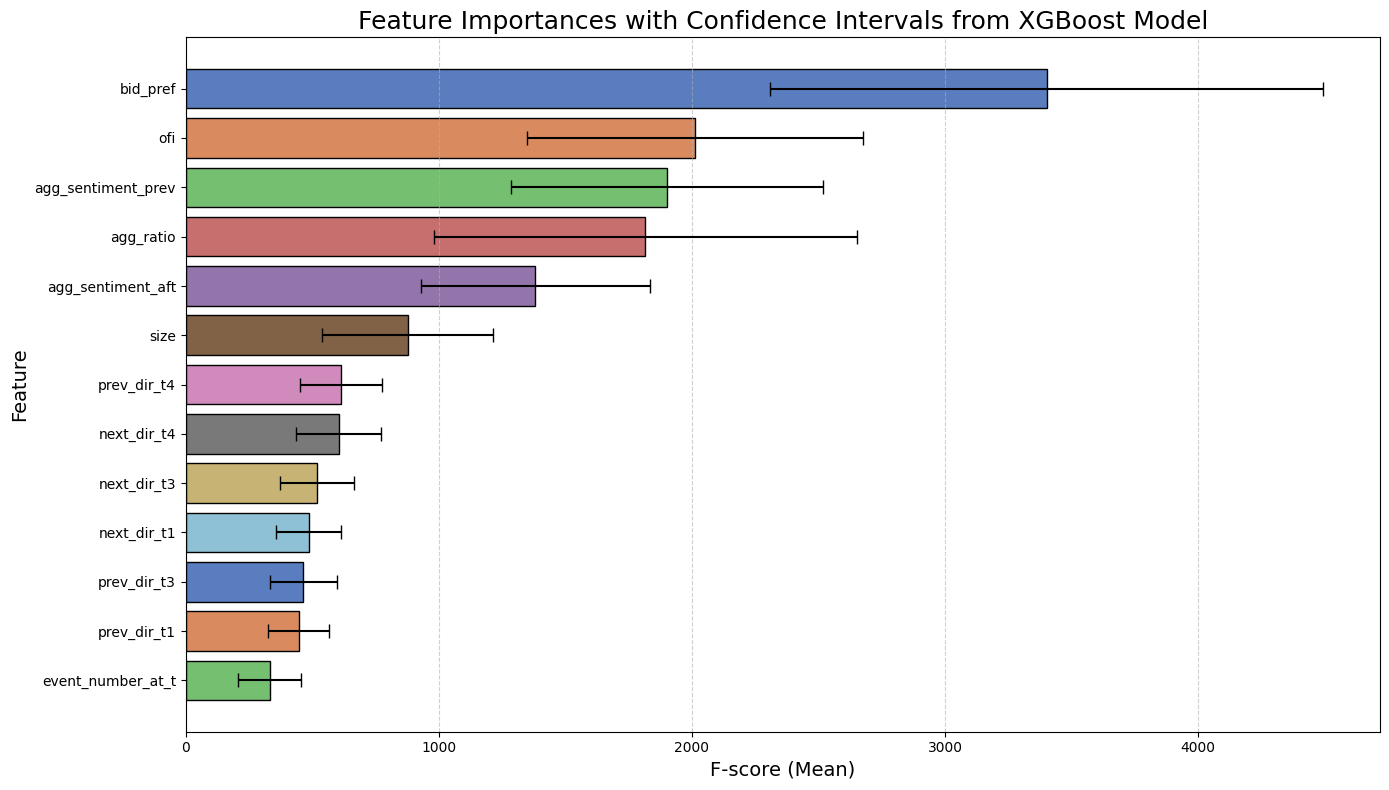

In [34]:
# Calculate the error (difference between mean and CI bounds)
results_importance['error_lower'] = results_importance['Mean'] - results_importance['lower_CI']
results_importance['error_upper'] = results_importance['higher_CI'] - results_importance['Mean']

# Create the barplot without error bars
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Mean', y='Feature', data=results_importance, palette='muted', edgecolor='black')

# Add the error bars manually using ax.errorbar()
ax.errorbar(results_importance['Mean'], results_importance['Feature'], xerr=[results_importance['error_lower'], results_importance['error_upper']], fmt='none', c='black', capsize=5)

# Set labels and title
plt.xlabel('F-score (Mean)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances with Confidence Intervals from XGBoost Model', fontsize=18)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6, axis='x')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
